In [1]:
import csv
import numpy as np
import pandas as pd
import re
from tqdm import tqdm
import os
import json
from dateutil.relativedelta import relativedelta
import datetime

import warnings

warnings.filterwarnings("ignore")
desired_width = 320
pd.set_option('display.width', desired_width)
pd.set_option('display.max_columns', 10)

In [2]:

df_org = pd.read_excel('../data/shumee_mckinsey.xlsx', index_col=None, engine='openpyxl')

df = df_org[['Data', 'Nazwa produktu']]
df


,Data,Nazwa produktu
0,2021-02-28 23:52:46,PEPCO Ramka na clip 53x63 cm srebrna
1,2021-02-28 23:50:05,shumee Ručně vyrobený kuchyňský dřez se sítkem...
2,2021-02-28 23:50:05,shumee Venkovní solární sprcha se sprchovou hl...
3,2021-02-28 23:48:57,Fontanna ze stali nierdzewnej do basenu ogrodo...
4,2021-02-28 23:39:51,"Krzesła biurowe, 2 szt., pomarańczowe, sztuczn..."
...,...,...
190543,2018-02-26 19:44:13,Kod rabatowy: shumeeLOVE
190544,2018-02-26 15:37:29,U.S. Polo - 43481_47130 XXL
190545,2018-02-26 15:20:26,Made in Italia - FEDERICA 36
190546,2018-02-26 02:08:48,Versace Jeans - E1VPBBT1_75416


In [3]:

clustered_productsJSON = None
clustered_products = {}
id_to_product = {}
with open('../data/clustered_products.json') as f:
    clustered_productsJSON = json.load(f)
for i in range(len(clustered_productsJSON)):
    for prd in clustered_productsJSON[i]:
        clustered_products[prd] = i
        id_to_product[i] = prd


In [4]:

# Przypisuję nazwę grupy jeśli istnieje, w przeciwnym wypadku nazwa produktu
df['group_name'] = df['Nazwa produktu'].apply(
    lambda x: id_to_product[clustered_products[x]] if x in clustered_products else x)
df['months'] = df['Data'].dt.to_period('M')

# df.drop('Data', inplace=True, axis=1)

top_sales = df[['group_name', 'months']].groupby('group_name').count().sort_values(by='months', ascending=False)


Zakres sprzedaży:
2018-08
2021-02


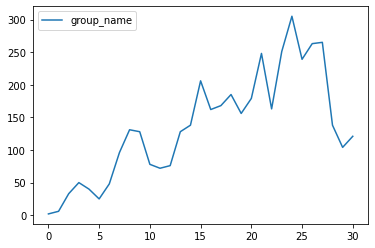

In [5]:

# od teraz analizuje jeden najlepiej sprzedający się produkt
# TODO: pętla po wszystkich / top x produktach

product_name = top_sales.iloc[0, :].name

product_sales = df[df['group_name'] == product_name]
product_sales_by_months = product_sales[['months', 'group_name']].groupby('months').count()
product_sales_by_months.reset_index(level=0, inplace = True)
product_sales_by_months.plot.line()
product_sales_by_months.columns = ['ds', 'y']
print('Zakres sprzedaży:')
print(product_sales['months'].min())
print(product_sales['months'].max())


predicted=155.638228, expected=248.000000
predicted=253.634561, expected=163.000000
predicted=171.645409, expected=251.000000
predicted=202.862641, expected=305.000000
predicted=247.729022, expected=239.000000
predicted=272.827882, expected=263.000000
predicted=259.477547, expected=265.000000
predicted=227.413933, expected=138.000000
predicted=183.047311, expected=104.000000
predicted=139.361813, expected=121.000000


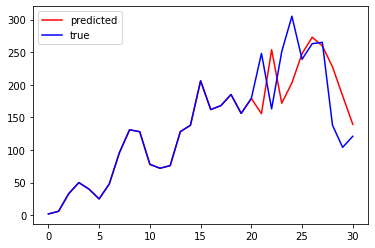

In [6]:

#ARIMA
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot
from random import random

# contrived dataset
data = product_sales_by_months['y'].tolist()

# ostatnie 10 do predykcji

train, test = data[0:-10], data[-10:]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts
# TODO: calculate MSE
# rmse = sqrt(mean_squared_error(test, predictions))
# print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes


pyplot.plot(train+predictions, color='red', label='predicted')
pyplot.plot(data, color='blue', label='true')
pyplot.legend()
pyplot.show()

